In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

### Introduction
In the introduction, we plot just one figure related to papers publication over the years.
We read the Scopus and Web of Science data about the number of papers published with topic **Augmented Reality** and **Education**

In [30]:
with open('data/Scopus_analyze_2020_10_01.csv') as scopus_file:
    scopus_data = scopus_file.readlines()
scopus_data = scopus_data[8:]
scopus_data
years = []
papersScopus = []
for item in scopus_data:
    year, paper = item.split(',')
    years.append(int(''.join(filter(str.isdigit, year))))
    papersScopus.append(int(''.join(filter(str.isdigit, paper))))
years.reverse()
papersScopus.reverse()

with open('data/WoS_analyze_2020_10_01.txt') as wos_file:
    wos_data = wos_file.readlines()
wos_data = wos_data[1:-12] # restrict to >2006 to be consistent with Scopus data
papersWos = []
for item in wos_data:
    _, paper, _ = item.split("\t")
    papersWos.append(int(''.join(filter(str.isdigit, paper))))
papersWos.reverse()

df = pd.DataFrame(list(zip(years, papersScopus, papersWos)), 
               columns =['Years', 'Scopus', 'WoS'])
df.head()

,Years,Scopus,WoS
0,2006,29,17
1,2007,34,31
2,2008,45,25
3,2009,46,41
4,2010,57,47


We also wants to plot the predicted amount of papers at the end of 2020. This is easy, as we just assume that for the fourth trimester the rate of publishing stays the same.

In [31]:
# papersExpected = np.empty((len(years), 2))
# papersExpected[:] = np.NaN
# papersExpected[-2, 0] = papersScopus[-2]
# papersExpected[-2, 1] = papersWos[-2]
# papersExpected[-1, 0] = np.int32(papersScopus[-1] * 4/3)
# papersExpected[-1, 1] = np.int32(papersWos[-1] * 4/3)
# df['Scopus (Expected)'] = papersExpected[:, 0]
# df['WoS (Expected)'] = papersExpected[:, 1]
# df.tail()

Now we simply create a lineplot of the numbr of papers over the years

<Figure size 1080x504 with 0 Axes>

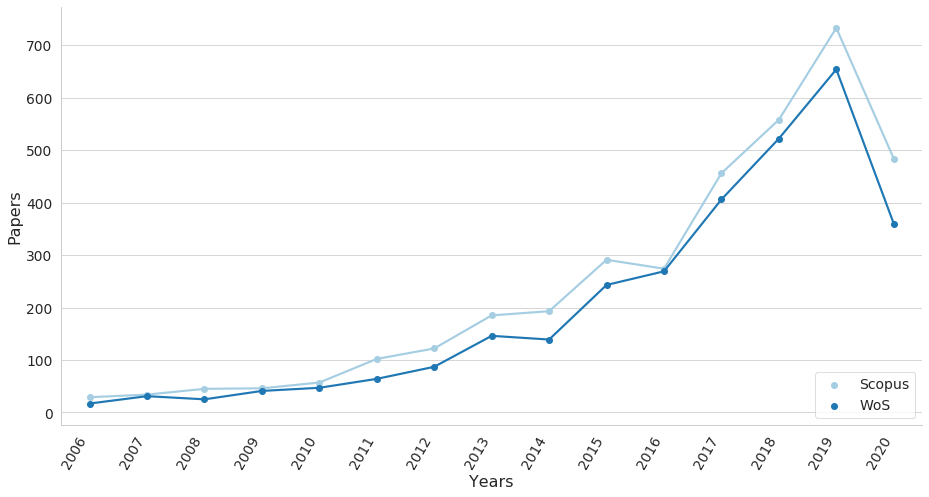

In [32]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.set_style("whitegrid")
sns.despine()
sns.set_palette(sns.color_palette("Paired"))
sns.set_context("paper", rc={"axes.titlesize":8,"axes.labelsize":16})

df_melt = df.melt('Years', var_name='Index',  value_name='Papers')
df_melt.head()

sns.catplot(x="Years", y="Papers", hue='Index',
            kind='point', height=7, aspect=13/7,
            legend=False, data=df_melt)

plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='normal',
    fontsize='x-large'
)

plt.yticks(
    fontweight='normal',
    fontsize='x-large'
)

plt.legend(loc='lower right', prop={'size': 14})
plt.tight_layout()
plt.savefig('figures/papers_over_years.svg', dpi=300)

### Methodology

Ok, now we go to the second section, about methodology. What we want to compute in this case is the agreement between the different raters, that is Cohen's kappa, defined as

$\kappa = \frac{p_0-p_e}{1-p_e}$

where $p_0$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement.

We start first with the interrater agreement for the selction of papers reading the abstracts. 

In [3]:
papers_for_agreement = 50
accepted_R1 = 23
accepted_R2 = 24
discarded_R1 = papers_for_agreement - accepted_R1
discarded_R2 = papers_for_agreement - accepted_R2
both_accepted = 22
both_discarded = 25
only_R1_accepted = 1
only_R2_accepted = 2

p_zero = (both_accepted + both_discarded) / papers_for_agreement
p_R1_yes = accepted_R1 / papers_for_agreement
p_R1_no = discarded_R1 / papers_for_agreement
p_R2_yes = accepted_R2 / papers_for_agreement
p_R2_no = discarded_R2 / papers_for_agreement
p_e = p_R1_yes * p_R2_yes + p_R1_no * p_R2_no

kappa = (p_zero - p_e) / (1 - p_e)
kappa

0.8796147672552166

Now we do the same, but for the rater agreement after actually reading the paper. The sample size in this case is smaller, as only 10 papers were read by both researchers.

In [8]:
papers_for_agreement = 10
accepted_R1 = 2
accepted_R2 = 3
discarded_R1 = papers_for_agreement - accepted_R1
discarded_R2 = papers_for_agreement - accepted_R2
both_accepted = 2
both_discarded = 7
only_R1_accepted = 0
only_R2_accepted = 1

p_zero = (both_accepted + both_discarded) / papers_for_agreement
p_R1_yes = accepted_R1 / papers_for_agreement
p_R1_no = discarded_R1 / papers_for_agreement
p_R2_yes = accepted_R2 / papers_for_agreement
p_R2_no = discarded_R2 / papers_for_agreement

p_e = p_R1_yes * p_R2_yes + p_R1_no * p_R2_no

kappa = (p_zero - p_e) / (1 - p_e)
kappa

0.7368421052631581

### Results

Here we create the figures for section 3, reading the data from the spreadsheets containing the answers to the Google Form filled by the researchers after reading each paper

In [41]:
df2 = pd.read_excel ('data/AR in Education SLR (Responses).xlsx', sheet_name='OnlyValid', header=0, nrows=92,
                    usecols='B,C,E:G,I:O,V')
df2.tail()

,Which paper are you reviewing? Please copy-paste the TITLE from the GSheet.,Interesting?,Is the application interactive?,Is the application multi-user?,Is the application collaborative?,What is the subject covered by the app?,What kind of AR technology is used? (please select all that apply),Is the code of the app publicly available?,What hardware does the app support?,Which software frameworks/libraries has been used to develop the app?,Does the paper provide information regarding the number of users who tested the app?,"If you answer was Yes, could you specify how many?",When was the paper published?
87,EmoFindAR: Evaluation of a mobile multiplayer ...,Yes,Yes,Yes,Yes,Emotional intelligence and communication skills,"Markerless (plane detection, user clicks to ad...",No,Phone,"Unity, PUN, Placenote",Yes,38.0,2020
88,Multi-sensual Augmented Reality in Interactive...,Yes,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...",Unspecified,No,PC with special keyboard with Braille display,Unspecified,Yes,13.0,2020
89,Voluminis: An Augmented Reality Mobile System ...,Yes,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Markerless (plane detection, user clicks to ad...",No,Phone,"Unity, ARCore",Yes,21.0,2020
90,Gamifying Early Foreign Language Learning,No,Yes,No,No,Foreign language,Unspecified,No,Tablet,Unspecified,Yes,38.0,2020
91,Using Augmented Reality to Stimulate Students ...,No,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Marker-based (QR, image or 3d model based)",No,"Phone, Tablet",Unspecified,Yes,70.0,2020


Before plotting anything, we just compute some numbers to include in the paper, like the number of studies presenting multiuser or collaborative app, as well as the studies published in 2018 or after.

In [51]:
publish_year_col=list(df2['When was the paper published?'])
after_2018 = publish_year_col.count(2018) + publish_year_col.count(2019) + publish_year_col.count(2020)
print(f"Published in 2018 or after = {after_2018}")
multiuser_col = df2["Is the application multi-user?"]
multiuser = multiuser_col[multiuser_col == "Yes"].count()
print(f"Apps with multiuser capabilities = {multiuser}")
collaborative_col = df2["Is the application collaborative?"]
collaborative = collaborative_col[collaborative_col == "Yes"].count()
print(f"Apps with collaborative capabilities = {collaborative}")

Published in 2018 or after = 65
Apps with multiuser capabilities = 17
Apps with collaborative capabilities = 13


We now then proceed to check the subjects covered in the studies analyzed in the review. 

In [72]:
subjects_resp =df2["What is the subject covered by the app?"].value_counts()
print(subjects_resp)

STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...)                                                           60
Humanities (First language, Art, History, Music, ...)                                                                     9
Foreign language                                                                                                          8
Physical education                                                                                                        2
Unspecified                                                                                                               2
STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Humanities (First language, Art, History, Music, ...)     2
Emotional intelligence and communication skills                                                                           1
3D modeling                                                                                                               1
STEM (Ma

There is some work to do before plotting. First of all, there is one case with both STEM and Humanities, we are going to remane this to "Multiple". Another response mixes STEM with a comment (probably an error filling the form. We will remove this entry and add the count to "STEM". Likewise, we will merge "Physical education" with "Physical education and Nutrition". Finally, we will group as "Other" all the remaining entries.


In [95]:
subjects_modified = {"STEM":0, "Humanities":0, "Foreign Language":0, "Physical Education":0,
                     "Multiple":0, "Other":0, "Unspecified":0}
subjects_dict =  dict(subjects_resp)
subjects_modified["STEM"] = subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...)"] + subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Museum. Different Animals, etc."]
subjects_modified["Humanities"] = subjects_dict["Humanities (First language, Art, History, Music, ...)"]
subjects_modified["Foreign Language"] = subjects_dict["Foreign language"]
subjects_modified["Physical Education"] = subjects_dict["Physical education"] + subjects_dict["Physiscal education and Nutrition"]
subjects_modified["Multiple"] = subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Humanities (First language, Art, History, Music, ...)"]
subjects_modified["Unspecified"] = subjects_dict["Unspecified"]
# Just sum together all the others
subjects_modified["Other"] = 7
subjects = pd.DataFrame.from_dict(subjects_modified, orient='index', columns=['Num. of papers'])
subjects.reset_index(inplace=True)
subjects = subjects.rename(columns={"index":"Subject"})


We are now ready to create the visualization. Again, we use Seaborn for this, and we will create an horizontal bar plot.

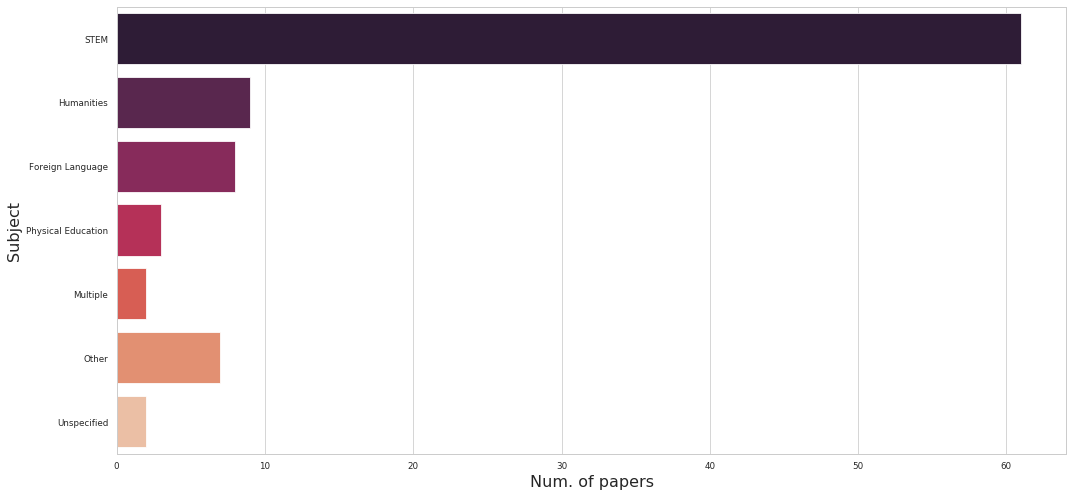

In [107]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.set_style("whitegrid")
sns.despine()
sns.set_context("paper", rc={"axes.titlesize":8,"axes.labelsize":16})

sns.barplot(x='Num. of papers', y='Subject', data=subjects, palette="rocket")
plt.tight_layout()
plt.savefig('figures/subjects.svg', dpi=300)

Now we want to do the same, but for the AR technology used

In [109]:
ar_tech_resp = df2["What kind of AR technology is used? (please select all that apply)"].value_counts()
print(ar_tech_resp)

Marker-based (QR, image or 3d model based)                                                                                            60
Unspecified                                                                                                                            9
Markerless (plane detection, user clicks to add 3d content, ...)                                                                       9
Marker-based (QR, image or 3d model based), Location based (GPS, bluetooth, wi-fi, accelerometer, ...)                                 4
Object recognition (Content added when specific person or object category is detected)                                                 3
Location based (GPS, bluetooth, wi-fi, accelerometer, ...)                                                                             2
Makey Makey boards used to command new projections                                                                                     2
It is more an immersive solution with pro

And similar to what we did for the subjects, we will group the values where appropriate

In [6]:
testers = [37,10,63,102,20,5,25,5,35,30,45,14,38,111,30,27,74,70,71,20,36,97,54,38,29,2,4,60,
106,92,32,93,68,58,23,60,70,35,8,8,15,20,18,26,24,66,58,290,60,50,20,5,76,31,24,33,24,24,38,52,
137,100,42,23,23,3,66,20,65]
len(testers)

69

In [7]:
df = pd.DataFrame({'Testers': testers})

In [9]:
fig = px.histogram(df, x="Testers", marginal="rug", nbins=20, color_discrete_sequence=['grey'], barmode="group")
fig.update_layout(paper_bgcolor = 'rgba(0,0,0,0)',
                  plot_bgcolor = 'rgba(0,0,0,0)',
                  xaxis = dict(
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 20
                  ))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Black')
fig.show()